In [36]:
import pyccl as ccl
from keras.models import Sequential
from keras.layers import Embedding, Dense
import numpy as np
from scipy.stats.qmc import LatinHypercube
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [49]:
param_list = ['Omega_b', 'Omega_c', 'h', 'sigma8', 'n_s']

param_ranges = [[0.046,0.053],[0.2,0.5],[0.67,0.76],[0.78,0.85],[0.8,1.1]]

print(len(param_list))
D = 5

n_samples = 1000

lh = LatinHypercube(D)

lh_samples = lh.random(n_samples)
print(lh_samples.shape)
for dim in range(D):
    lh_samples[:,dim] = lh_samples[:,dim]*(param_ranges[dim][1]-param_ranges[dim][0])+param_ranges[dim][0]

5
(1000, 5)


In [65]:
pk_lins = []

k_arr = np.geomspace(1e-4,1e2,100)
a = 1

for i in range(n_samples):
    cosmo = ccl.Cosmology(Omega_c=lh_samples[i,1], 
                            Omega_b=lh_samples[i,0], 
                            h=lh_samples[i,2], 
                            sigma8=lh_samples[i,3], 
                            n_s=lh_samples[i,4]
                            )
    pk_lin = cosmo.linear_matter_power(k_arr, a)
    pk_lins.append(pk_lin)

    

In [81]:
# Number of input features
input_features = 5

# Sample dataset (replace with your actual data)
# Here we generate random data for demonstration purposes
np.random.seed(0)
X = lh_samples
y = np.array(pk_lins)

# Standardize the inputs
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Create a Sequential model
model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(input_features,)))

# Additional hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer - assuming a single output for regression
model.add(Dense(100, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32)

# Evaluate the model
model.evaluate(X_test, y_test)


Epoch 1/1000
25/25 [==============================] - 1s 3ms/step - loss: 432620544.0000
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 432584256.0000
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 431934176.0000
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 424737024.0000
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 372783008.0000
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 209244960.0000
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 90399088.0000
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 43644840.0000
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 25623324.0000
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 18949970.0000
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 16716892.0000
Epoch 12/1000
25/25 [===

49529.703125

1/1 [==============================] - 0s 57ms/step


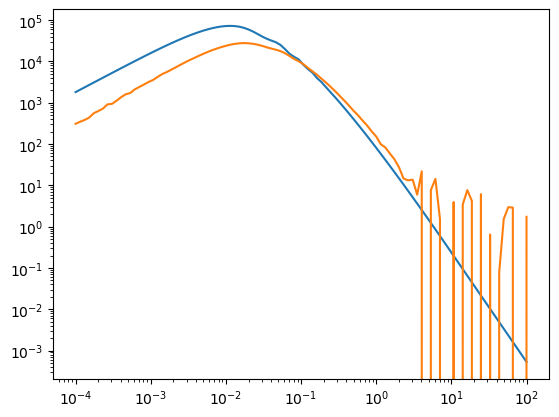

In [82]:
pk_true = ccl.Cosmology(Omega_c=0.25, 
                        Omega_b=0.05, 
                        h=0.7, 
                        sigma8=0.8, 
                        n_s=0.96
                        ).linear_matter_power(k_arr, a)

pk_pred = model.predict(np.array([[0.05,0.25,0.7,0.8,0.96]]))

plt.loglog(k_arr, pk_true, label='True')
plt.loglog(k_arr, pk_pred[0], label='Predicted')